<a href="https://colab.research.google.com/github/Retmixer/FuelDataSet/blob/main/FuelDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка данных об автомобилях...
Размерность данных: (38113, 81)

Первые 5 строк:
   vehicle_id  year        make               model  \
0       26587  1984  Alfa Romeo           GT V6 2.5   
1       27705  1984  Alfa Romeo           GT V6 2.5   
2       26561  1984  Alfa Romeo  Spider Veloce 2000   
3       27681  1984  Alfa Romeo  Spider Veloce 2000   
4       27550  1984  AM General   DJ Po Vehicle 2WD   

                         class          drive       transmission  \
0             Minicompact Cars            NaN     Manual 5-Speed   
1             Minicompact Cars            NaN     Manual 5-Speed   
2                  Two Seaters            NaN     Manual 5-Speed   
3                  Two Seaters            NaN     Manual 5-Speed   
4  Special Purpose Vehicle 2WD  2-Wheel Drive  Automatic 3-Speed   

  transmission_type  engine_index engine_descriptor  ...  \
0               NaN          9001             (FFS)  ...   
1               NaN          9005    (FFS) CA model  ... 

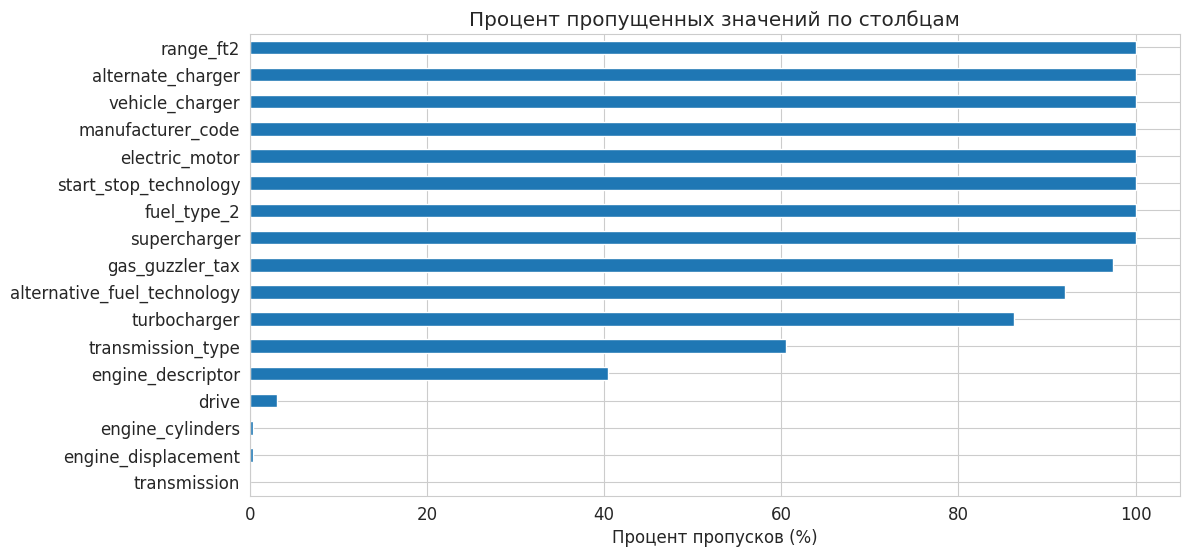

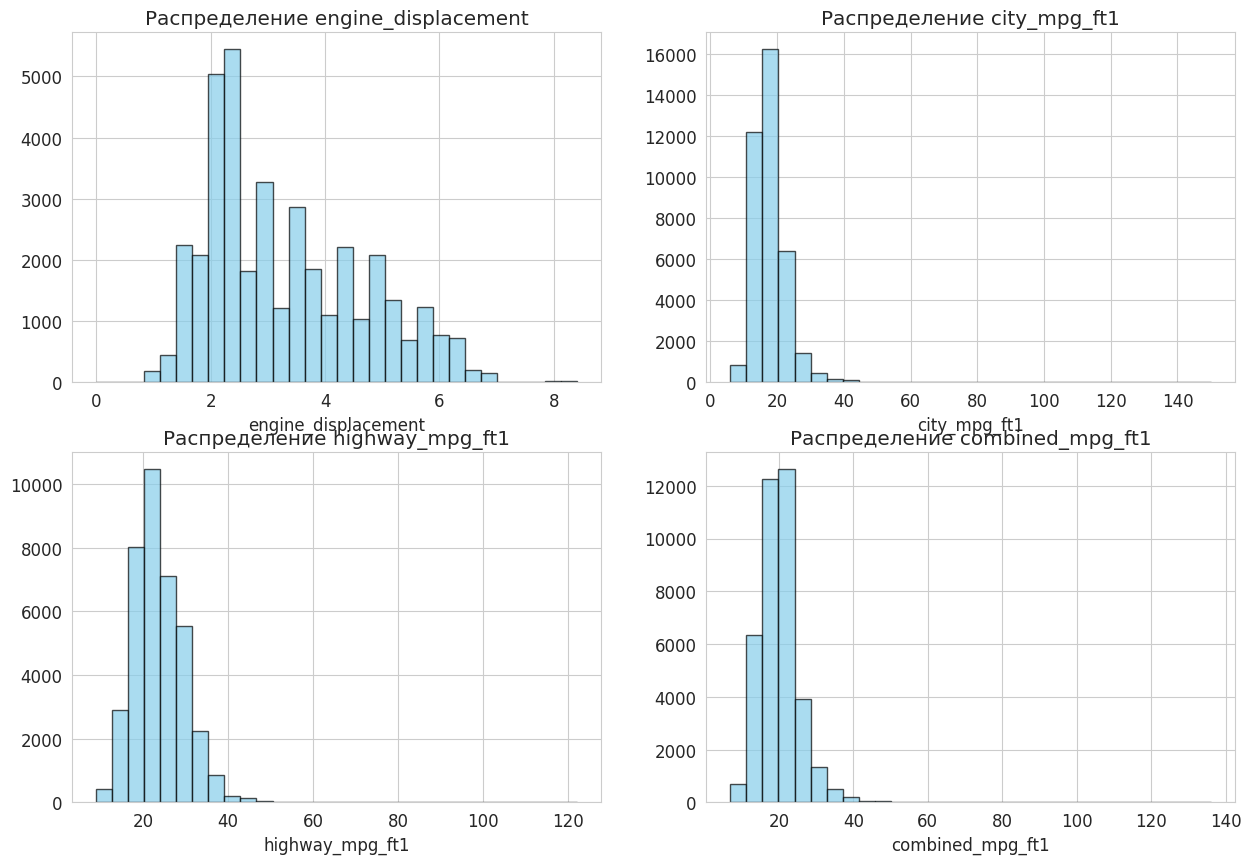

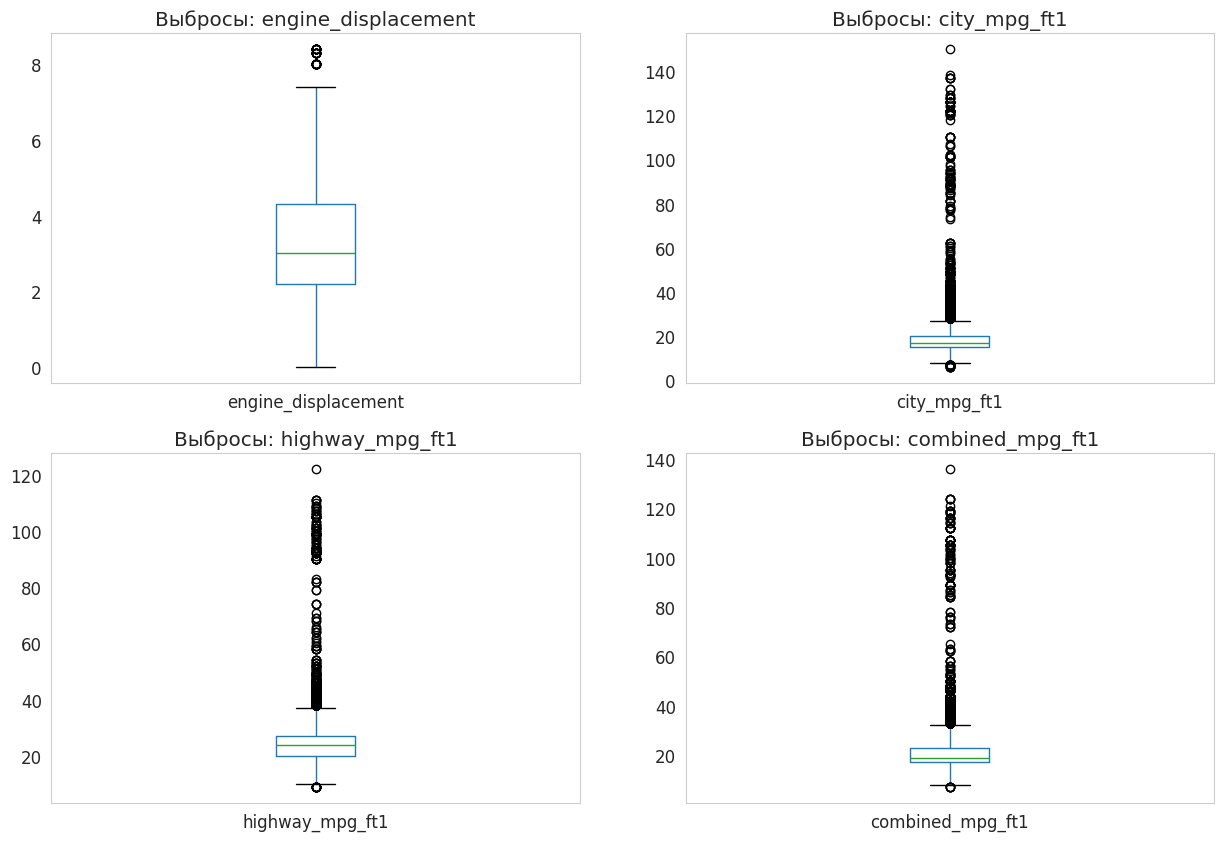

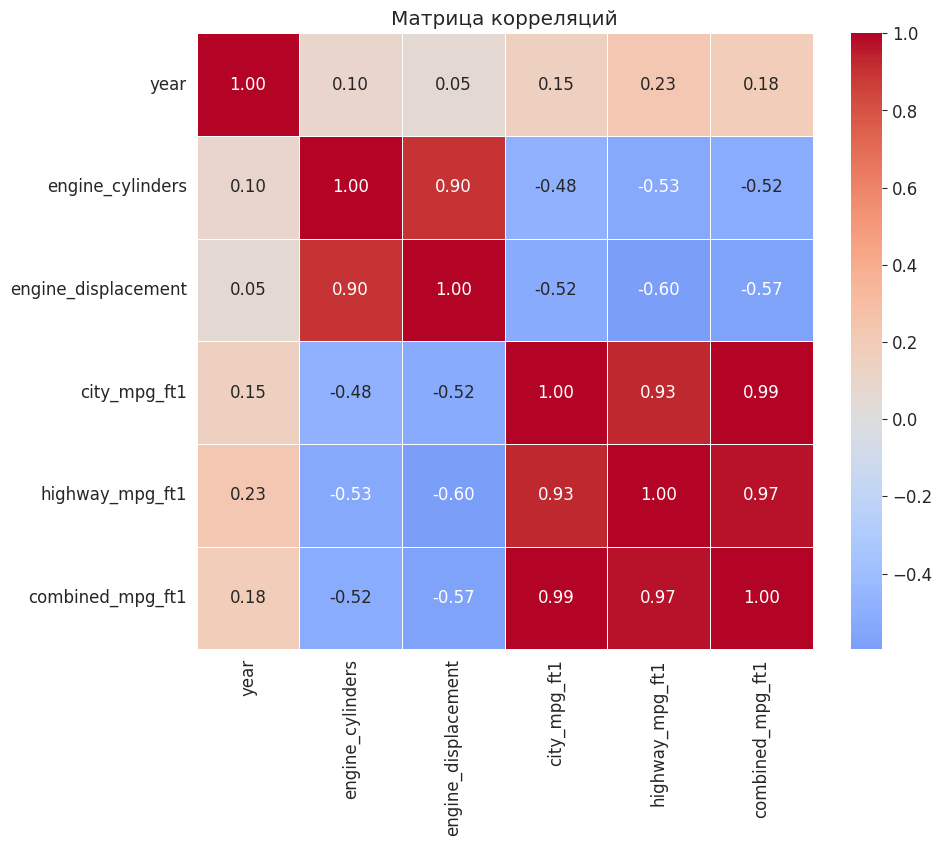

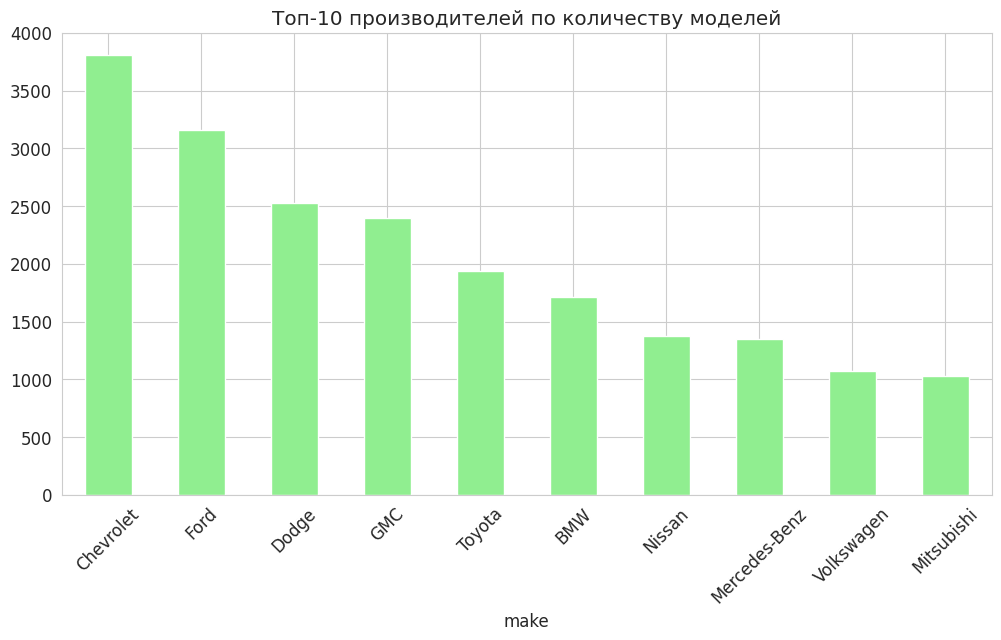

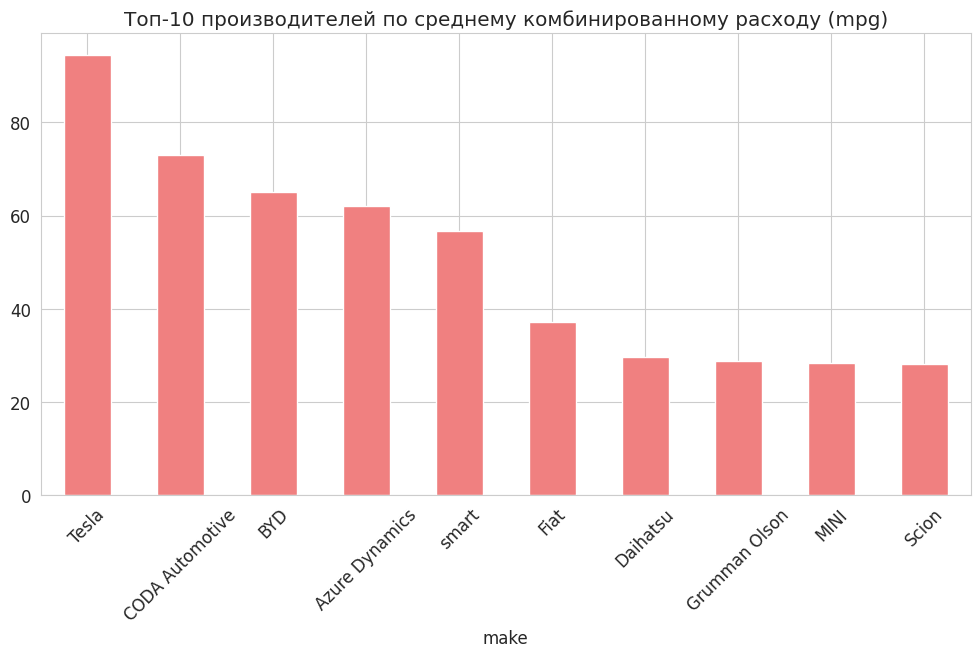

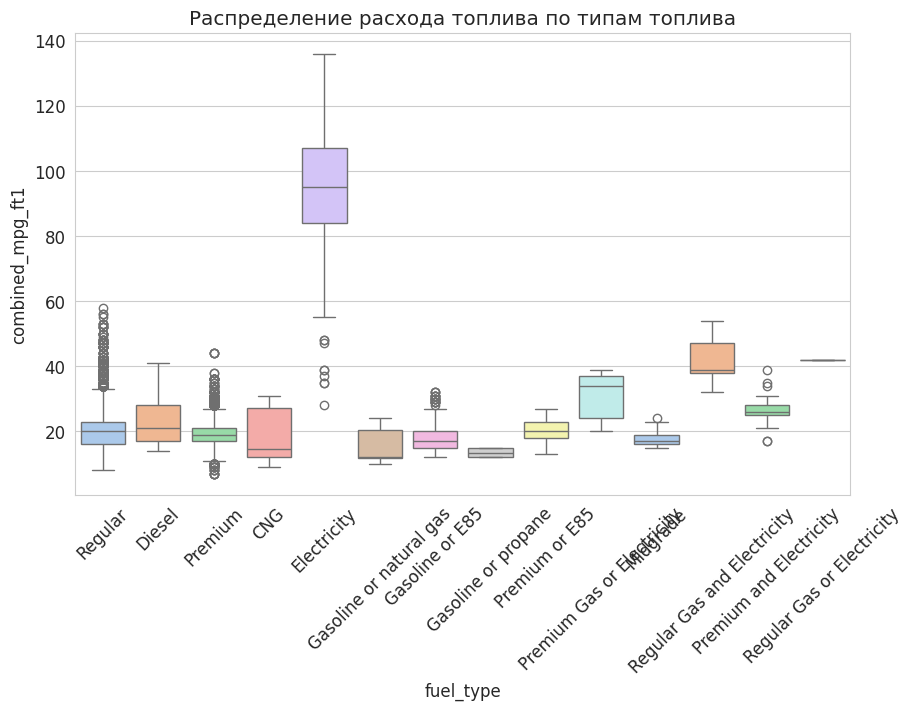

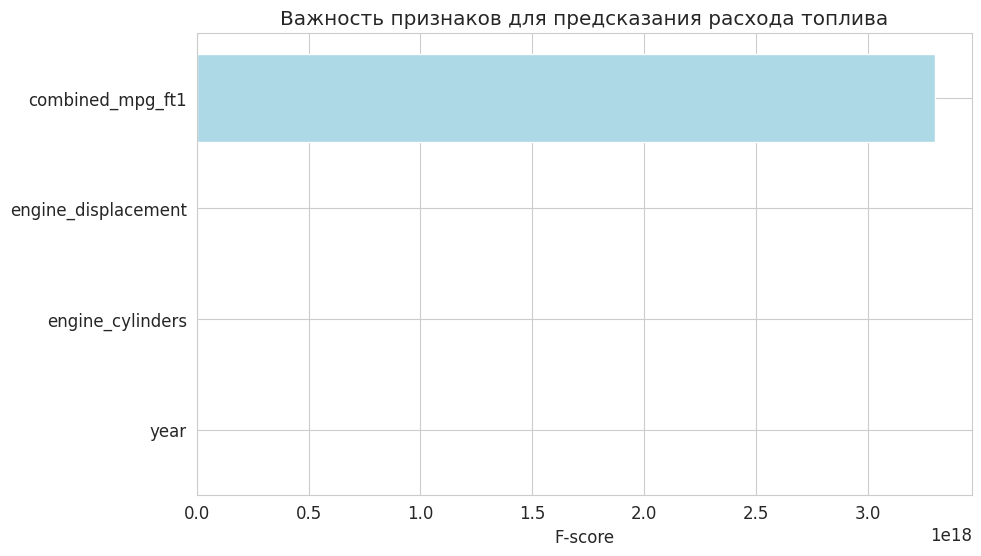

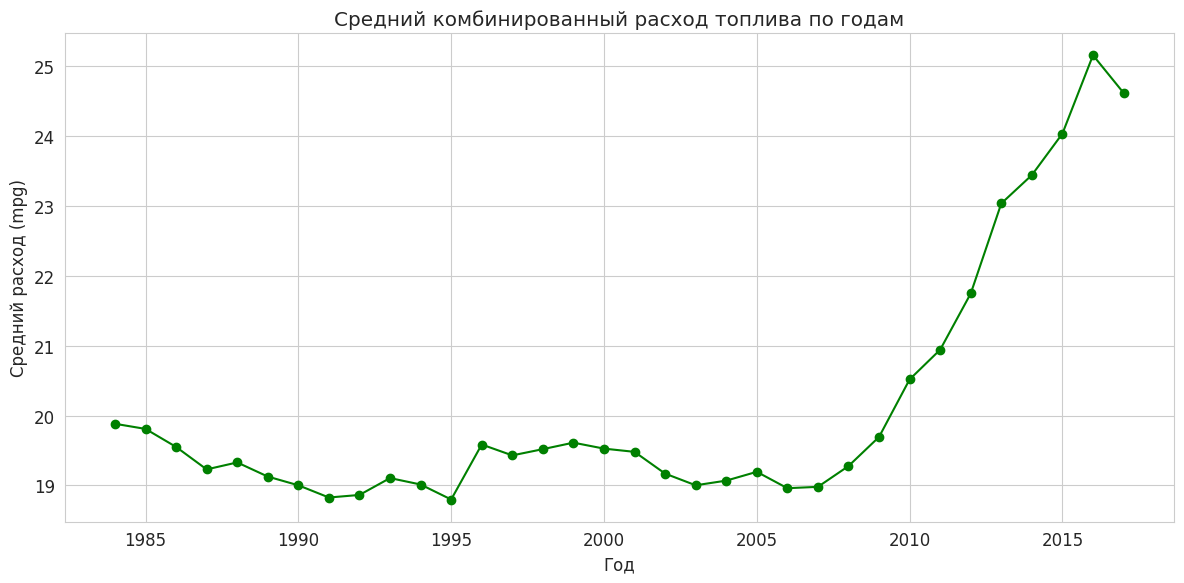

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

#  ЗАГРУЗКА ДАННЫХ
print("Загрузка данных об автомобилях...")
df = pd.read_csv('fuel.csv')

#  ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ
print(f"Размерность данных: {df.shape}")
print("\nПервые 5 строк:")
print(df.head())

print("\nИнформация о данных:")
df.info()

print("\nСтатистика числовых признаков:")
print(df.describe())

#  ПРОВЕРКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
print("\nПропущенные значения:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Визуализация пропусков
plt.figure(figsize=(12, 6))
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0]
missing_percent.sort_values(ascending=True).plot(kind='barh')
plt.title('Процент пропущенных значений по столбцам')
plt.xlabel('Процент пропусков (%)')

#  ВЫБОР ПРИЗНАКОВ ДЛЯ АНАЛИЗА
# Выберем наиболее интересные признаки для анализа расхода топлива
selected_features = [
    'make', 'model', 'year', 'class', 'drive', 'transmission',
    'engine_cylinders', 'engine_displacement', 'fuel_type',
    'city_mpg_ft1', 'highway_mpg_ft1', 'combined_mpg_ft1'
]

# Создаем новый датафрейм только с выбранными признаками
df_clean = df[selected_features].copy()

#  ОБРАБОТКА ПРОПУСКОВ
print("\nОбработка пропущенных значений...")

# Для числовых признаков заполняем медианой
numeric_cols = ['engine_cylinders', 'engine_displacement', 'city_mpg_ft1',
               'highway_mpg_ft1', 'combined_mpg_ft1']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Для категориальных заполняем модой
categorical_cols = ['make', 'model', 'class', 'drive', 'transmission', 'fuel_type']
for col in categorical_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown')

print("Пропуски обработаны")

#  АНАЛИЗ РАСПРЕДЕЛЕНИЙ
print("\nАнализ распределений...")

# Гистограммы числовых признаков
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

numeric_features_to_plot = ['engine_displacement', 'city_mpg_ft1', 'highway_mpg_ft1', 'combined_mpg_ft1']
for idx, col in enumerate(numeric_features_to_plot):
    if idx < len(axes):
        df_clean[col].hist(bins=30, ax=axes[idx], alpha=0.7, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Распределение {col}')
        axes[idx].set_xlabel(col)

#  АНАЛИЗ ВЫБРОСОВ
print("\nАнализ выбросов...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_features_to_plot):
    if idx < len(axes):
        df_clean.boxplot(column=col, ax=axes[idx], grid=False)
        axes[idx].set_title(f'Выбросы: {col}')

# КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
print("\nКорреляционный анализ...")

# Выбираем только числовые признаки для корреляционной матрицы
numeric_df = df_clean.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Матрица корреляций')

#  АНАЛИЗ ПО ПРОИЗВОДИТЕЛЯМ
print("\nАнализ по производителям...")

# Топ-10 производителей по количеству моделей
top_makes = df_clean['make'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_makes.plot(kind='bar', color='lightgreen')
plt.title('Топ-10 производителей по количеству моделей')
plt.xticks(rotation=45)

# Средний расход топлива по производителям
plt.figure(figsize=(12, 6))
df_grouped = df_clean.groupby('make')['combined_mpg_ft1'].mean().sort_values(ascending=False).head(10)
df_grouped.plot(kind='bar', color='lightcoral')
plt.title('Топ-10 производителей по среднему комбинированному расходу (mpg)')
plt.xticks(rotation=45)

#  АНАЛИЗ ПО ТИПУ ТОПЛИВА
print("\nАнализ по типу топлива...")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='fuel_type', y='combined_mpg_ft1', palette='pastel')
plt.title('Распределение расхода топлива по типам топлива')
plt.xticks(rotation=45)

# ПРЕДОБРАБОТКА ДЛЯ МОДЕЛИРОВАНИЯ
print("\nПредобработка данных...")

df_model = df_clean.copy()

# Кодируем категориальные переменные
label_encoders = {}
for col in categorical_cols:
    if col in df_model.columns:
        le = LabelEncoder()
        df_model[col + '_encoded'] = le.fit_transform(df_model[col].astype(str))
        label_encoders[col] = le

# Масштабируем числовые признаки
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_model[numeric_cols])
df_model[numeric_cols] = scaled_features

print("Данные подготовлены для моделирования")

# ОТБОР ПРИЗНАКОВ
print("\nОтбор наиболее важных признаков...")

# Готовим данные для отбора признаков
feature_cols = [col for col in df_model.columns if col not in
               ['make', 'model', 'class', 'drive', 'transmission', 'fuel_type',
                'city_mpg_ft1', 'highway_mpg_ft1'] and 'encoded' not in col]

X = df_model[feature_cols]
y = df_model['combined_mpg_ft1']  # Целевая переменная - комбинированный расход

# Отбираем топ-8 признаков
selector = SelectKBest(score_func=f_regression, k=min(8, len(feature_cols)))
X_selected = selector.fit_transform(X, y)
selected_features_names = X.columns[selector.get_support()]

print(f"Отобрано {len(selected_features_names)} признаков:")
for i, feature in enumerate(selected_features_names, 1):
    score = selector.scores_[selector.get_support()][i-1]
    print(f"  {i}. {feature} (score: {score:.2f})")

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
feature_scores = pd.DataFrame({
    'feature': selected_features_names,
    'score': selector.scores_[selector.get_support()]
}).sort_values('score', ascending=True)

plt.barh(feature_scores['feature'], feature_scores['score'], color='lightblue')
plt.title('Важность признаков для предсказания расхода топлива')
plt.xlabel('F-score')

#  СОЗДАНИЕ ФИНАЛЬНОГО ДАТАСЕТА
final_features = ['make', 'model', 'year', 'combined_mpg_ft1'] + selected_features_names.tolist()
final_dataset = df_clean[final_features].copy()

print(f"\nФинальный датасет создан")
print(f"Размер: {final_dataset.shape}")
print(f"Признаки: {final_features}")

#АНАЛИЗ ТЕНДЕНЦИЙ ПО ГОДАМ
print("\nАнализ тенденций по годам...")

plt.figure(figsize=(12, 6))
yearly_avg = df_clean.groupby('year')['combined_mpg_ft1'].mean()
yearly_avg.plot(kind='line', marker='o', color='green')
plt.title('Средний комбинированный расход топлива по годам')
plt.xlabel('Год')
plt.ylabel('Средний расход (mpg)')

# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
final_dataset.to_csv('processed_car_data.csv', index=False, encoding='utf-8')

print("\n" + "="*50)
print("ИТОГОВЫЙ ОТЧЕТ")
print("="*50)
print(f"• Исходный размер данных: {df.shape}")
print(f"• Финальный размер данных: {final_dataset.shape}")
print(f"• Обработано пропущенных значений: {df.isnull().sum().sum() - df_clean.isnull().sum().sum()}")
print(f"• Отобрано ключевых признаков: {len(selected_features_names)}")
print(f"• Лучшие признаки: {', '.join(selected_features_names[:3])}")
print(f"• Данные сохранены в файл: 'processed_car_data.csv'")

# Показать финальный датасет
print("\nФИНАЛЬНЫЙ ДАТАСЕТ (первые 10 строк):")
print(final_dataset.head(10))

# Показать все графики
plt.tight_layout()
plt.show()